LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [32]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [33]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.4.3


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [34]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [35]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [36]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

First we generate return scenario data using Monte Carlo method based on the moments of historical prices.  

In [37]:
# Number of scenarios
T = 99999

# Mean and covariance of historical log-returns.  
m_log, S_log = compute_inputs(df_prices, return_log=True)

# Generate logarithmic return scenarios assuming normal distribution
scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, T)
    
# Convert logarithmic return scenarios to linear return scenarios 
scenarios_lin = np.exp(scenarios_log) - 1

# Scenario probabilities
p = np.ones(T) / T

We would like to optimize the 95% CVaR of the portfolio loss distribution.

In [38]:
# Confidence level
alpha = 0.95

In [39]:
# Primal CVaR formula (for testing)
def CVaR(alpha, p, q):
    """
    Computes CVaR using primal formula. 
    NOTE: Inputs p and q should be numpy arrays.
    """
    # We need to be careful that math index starts from 1 but numpy starts from 0 (matters in formulas like ceil(alpha * T))
    T = q.shape[0]
    sort_idx = np.argsort(q)
    sorted_q = q[sort_idx]
    sorted_p = p[sort_idx]
    
    # Starting index 
    i_alpha = np.sort(np.nonzero(np.cumsum(sorted_p) >= alpha)[0])[0]

    # Weight of VaR component in CVaR
    lambda_alpha = (np.sum(sorted_p[:(i_alpha + 1)]) - alpha) / (1 - alpha)    
    
    # CVaR
    var = sorted_q[i_alpha]
    cvar = lambda_alpha * sorted_q[i_alpha] + np.dot(sorted_p[(i_alpha + 1):], sorted_q[(i_alpha + 1):]) / (1 - alpha)
    
    return var, cvar

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [40]:
# max(x, y) <= t
def maximum(M, x, y, t):
    M.constraint(Expr.sub(t, x), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(t, y), Domain.greaterThan(0.0))
    

def EfficientFrontier(N, T, m, R, p, alpha, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is constrained to take only positive values. 
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Auxiliary variables.
        t = M.variable("t", 1, Domain.unbounded())
        u = M.variable("u", T, Domain.unbounded())
        
        # Constraint modeling maximum
        maximum(M, Expr.sub(Expr.mul(-R, x), Expr.repeat(t, T, 0)), Expr.constTerm(T, 0.0), u)
        
        # Objective
        delta = M.parameter()
        cvar_term = Expr.add(t, Expr.mul(1/(1-alpha), Expr.dot(p, u)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, cvar_term)))
        
        # Create DataFrame to store the results.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d)
        
            # Solve optimization
            M.solve()
            # Check if the solution is an optimal point
            solsta = M.getPrimalSolutionStatus()
            if (solsta != SolutionStatus.Optimal):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = t.level()[0] + 1/(1-alpha) * np.dot(p, u.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)
            
            # Check CVaR value using primal formula 
            var, cvar = CVaR(alpha, p, -R @ x.level())
            print(f"""Relative difference between primal and dual Var and CVaR (%): 
                      {(var - t.level()[0]) / t.level()[0] * 100:.6f}, 
                      {(cvar - portfolio_risk) / portfolio_risk * 100:.6f}""")

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [41]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, _ = compute_inputs(df_prices)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [42]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=2, num=20)[::-1]
df_result = EfficientFrontier(N, T, m, scenarios_lin, p, alpha, deltas)

Relative difference between primal and dual CVaR (%): 1.4161786599716532e-10
Relative difference between primal and dual VaR (%): (0.027736024649563776, 0.027736020959021005)
Relative difference between primal and dual VaR (%): 1.3305956092774767e-05
Relative difference between primal and dual CVaR (%): 8.15138839549319e-09
Relative difference between primal and dual VaR (%): (0.027782504118262386, 0.027782503676069256)
Relative difference between primal and dual VaR (%): 1.5916244788122963e-06
Relative difference between primal and dual CVaR (%): 9.349080447210802e-10
Relative difference between primal and dual VaR (%): (0.027640378059852443, 0.02764037080030987)
Relative difference between primal and dual VaR (%): 2.6264273456005898e-05
Relative difference between primal and dual CVaR (%): -8.446379175621044e-11
Relative difference between primal and dual VaR (%): (0.027244346684367447, 0.027244346665335425)
Relative difference between primal and dual VaR (%): 6.985677696569969e-08
R

Check the results.

In [43]:
df_result

,delta,obj,return,risk,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,-9.670191,0.364457,0.100346,0.0,0.0,0.075496,0.0,0.103786,0.599174,0.221543,0.0
1,69.519280,-6.611442,0.365206,0.100356,0.0,0.0,0.072194,0.0,0.104977,0.601108,0.221721,0.0
2,48.329302,-4.484791,0.365987,0.100369,0.0,0.0,0.068695,0.0,0.105930,0.603444,0.221931,0.0
3,33.598183,-3.005991,0.367486,0.100407,0.0,0.0,0.062622,0.0,0.109659,0.606404,0.221315,0.0
4,23.357215,-1.977525,0.368877,0.100457,0.0,0.0,0.056535,0.0,0.111215,0.611089,0.221161,0.0
5,16.237767,-1.261894,0.371701,0.100605,0.0,0.0,0.044969,0.0,0.115894,0.619923,0.219214,0.0
6,11.288379,-0.763400,0.375156,0.100861,0.0,0.0,0.030203,0.0,0.120586,0.631022,0.218189,0.0
7,7.847600,-0.415547,0.380925,0.101493,0.0,0.0,0.005567,0.0,0.129747,0.647615,0.217071,0.0
8,5.455595,-0.172264,0.383513,0.101873,0.0,0.0,0.000000,0.0,0.140647,0.656094,0.203259,0.0
9,3.792690,-0.002597,0.385309,0.102277,0.0,0.0,0.000000,0.0,0.151508,0.664952,0.183540,0.0


## Visualize the results

Plot the efficient frontier.

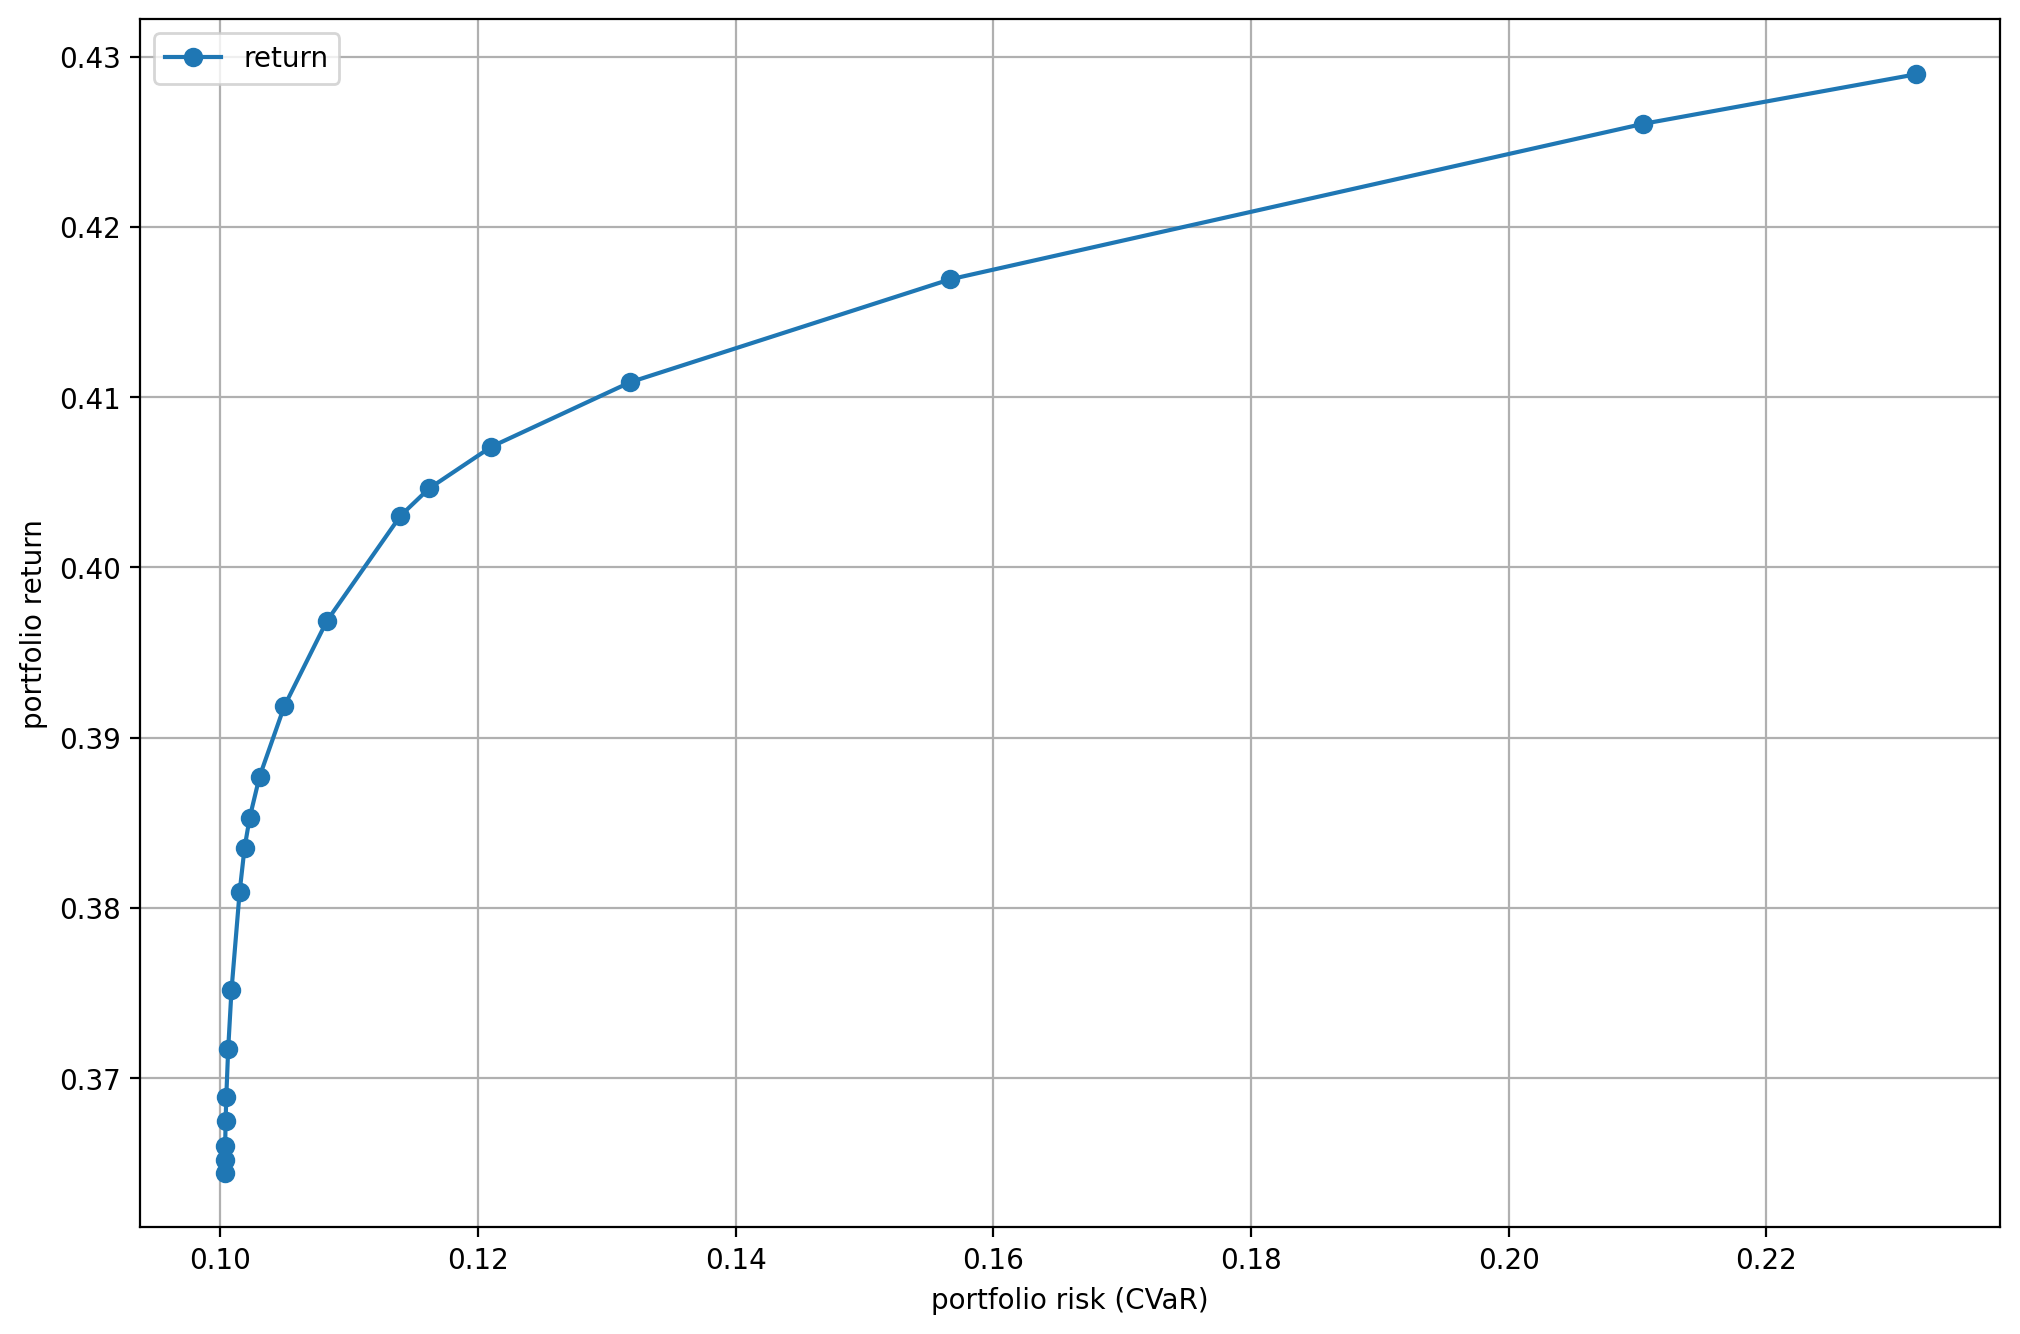

In [44]:
ax = df_result.plot(x="risk", y="return", style="-o", 
                    xlabel="portfolio risk (CVaR)", ylabel="portfolio return", grid=True)   
ax.legend(["return"]);

Plot the portfolio composition.

In [45]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

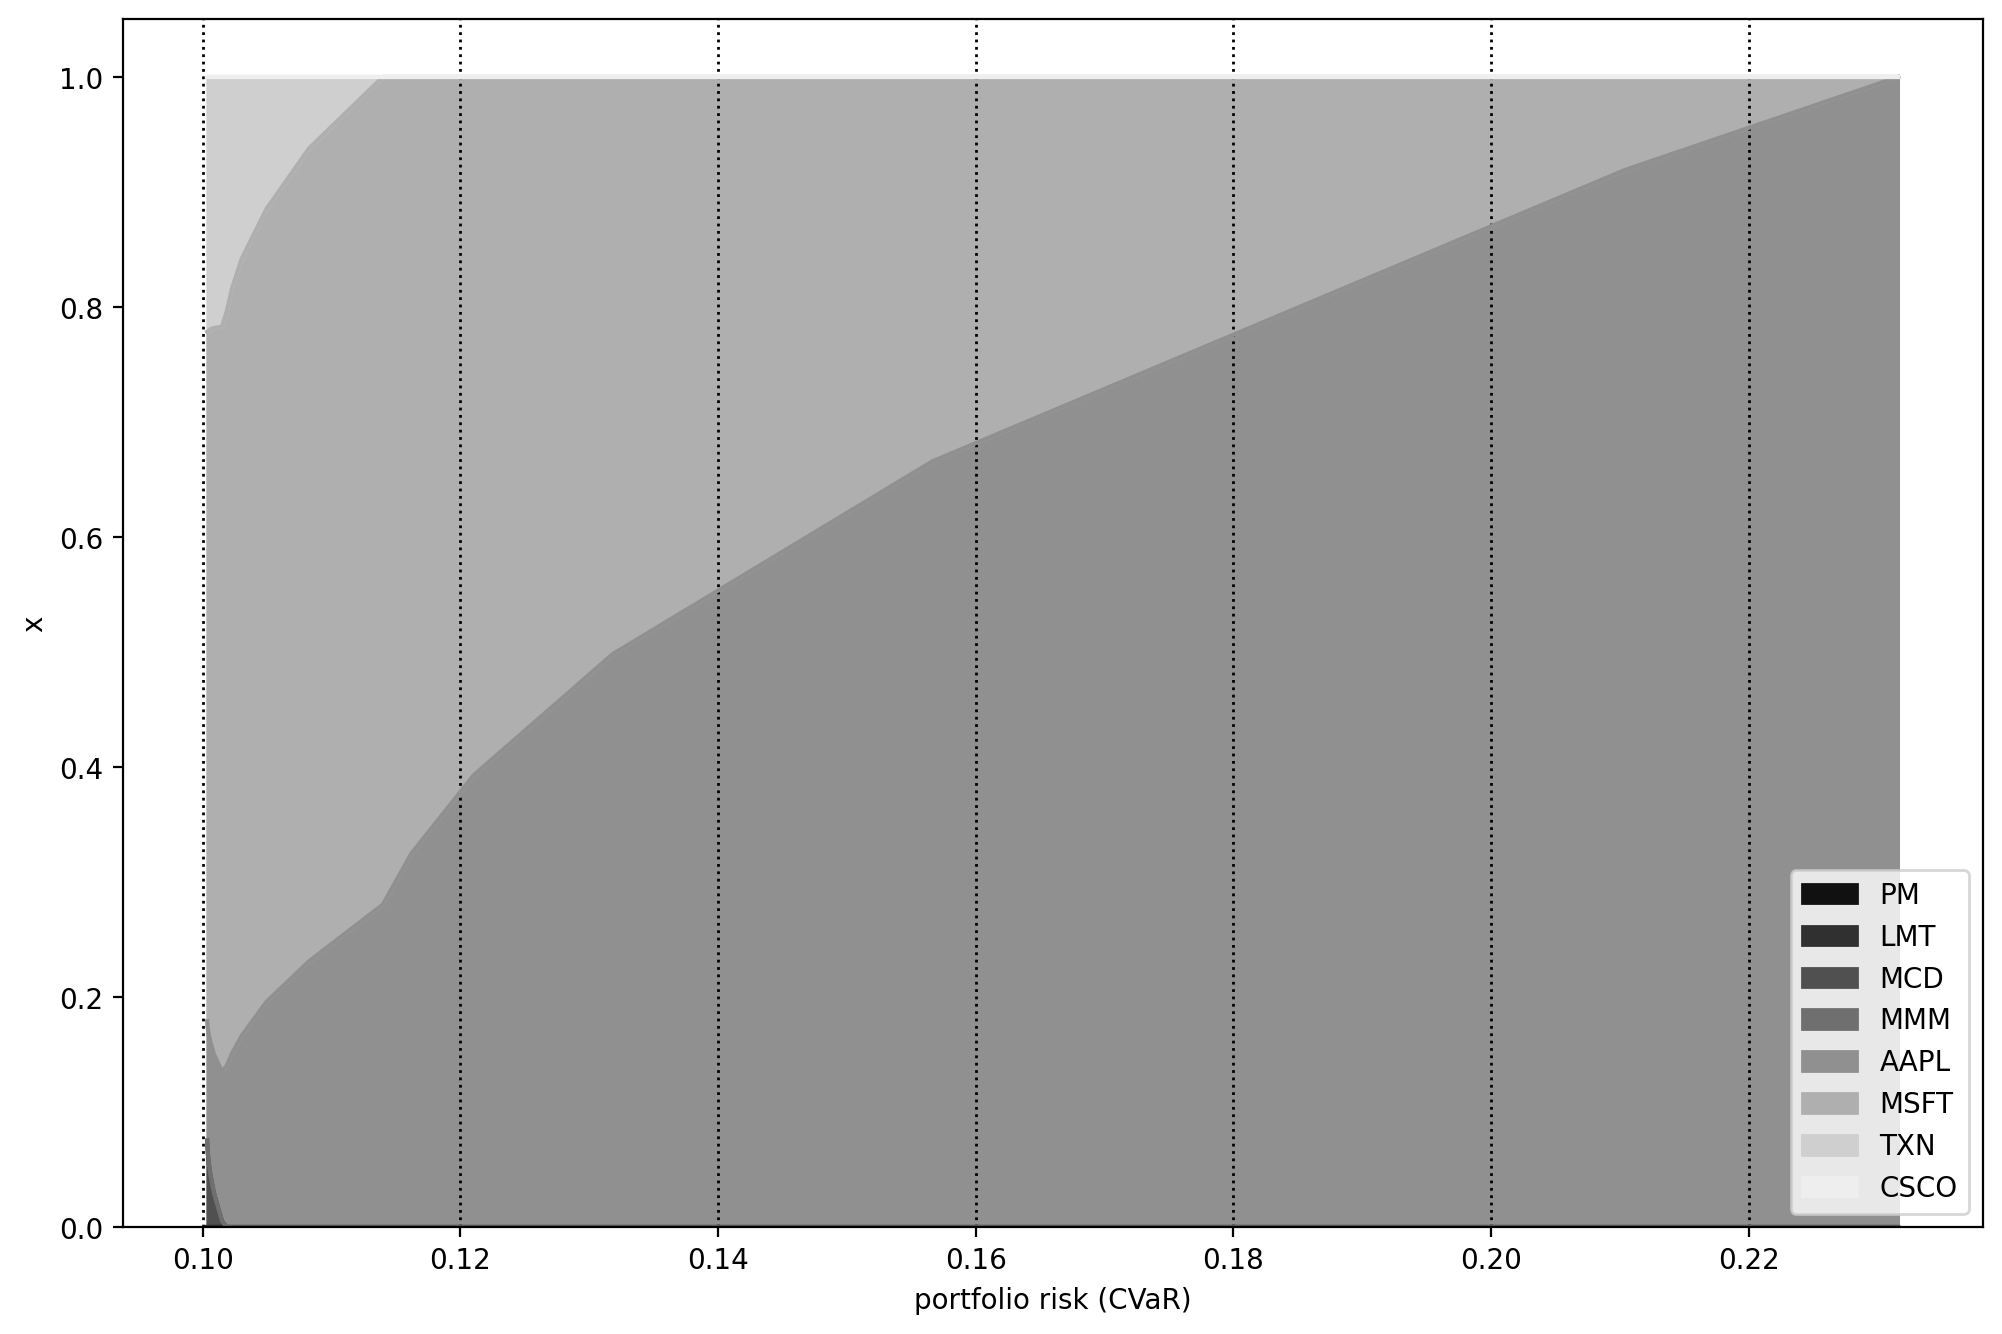

In [46]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (CVaR)', ylabel="x") 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)